In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch

loss=1.605975866317749


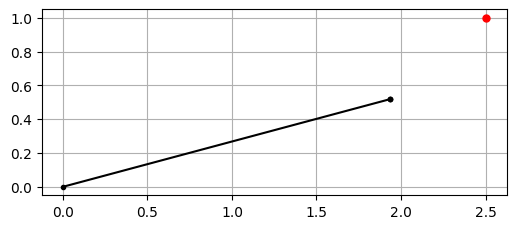

In [132]:

lengths = torch.tensor([2.0, 1.0, 0.5], requires_grad=True)

def fk(a):

    # a = torch.tensor([0.0], requires_grad=True)
    # pos_out = torch.zeros((len(angles)+1, 2), requires_grad=True)

    # for i, length in enumerate(lengths):
        
    #     a2 = a.clone()
    #     a2 += angles_out[i]
    #     a = a2

    #     pos_out2 = pos_out.clone()
    #     pos_out2[i+1,:] = pos_out2[i,:] + torch.tensor([torch.cos(a), torch.sin(a)], requires_grad=True) * length
    #     pos_out = pos_out2

    # return pos_out

    return torch.tensor([
        [0.0, 0.0],
        [torch.cos(a[0])*lengths[0], torch.sin(a[0])*lengths[0]],
        [torch.cos(a[0])*lengths[0], torch.sin(a[0])*lengths[0]],
        [torch.cos(a[0])*lengths[0], torch.sin(a[0])*lengths[0]],
    ], requires_grad=True)



pos_in = torch.tensor([2.5, 1.0])
angles_out = torch.tensor([
    1.0/180.0*np.pi*15.0, 
    1.0/180.0*np.pi*45.0, 
    1.0/180.0*np.pi*-60.0
])

pos_fk = fk(angles_out)

def loss_fn(pos_in, angles_out):

    pos_fk = fk(angles_out)

    pos_tail = pos_fk[-1]

    # distance = np.linalg.norm(pos_tail-pos_in)**2
    # loss += distance

    mse = torch.sum((pos_tail-pos_in)**2)
    mae = torch.sum(torch.abs(pos_tail-pos_in))
    loss = mse + mae

    # loss = torch.sum(angles_out**2) + torch.sum(torch.abs(angles_out))

    return loss

loss = loss_fn(pos_in, angles_out)
print(f"loss={loss}")

matplotlib.rcParams['figure.figsize'] = [6,6]
fig, ax = plt.subplots()

pos_fk_numpy = pos_fk.detach().numpy()

ax.plot(pos_fk_numpy[:,0], pos_fk_numpy[:,1], color="black", ms=3, marker="o")
ax.plot(pos_in[0], pos_in[1], color="red", ms=5, marker="o")
ax.set_aspect("equal")
ax.grid()

plt.show()


In [396]:
from torchsummary import summary
import torch.nn as nn

pos_in = torch.tensor([2.5, 1.0])

model = nn.Sequential(
    nn.Linear(pos_in.shape[0], 16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.ReLU(),
    # nn.Linear(32, 64),
    # nn.ReLU(),
    # nn.Linear(64, 128),
    # nn.ReLU(),
    # nn.Linear(128, 64),
    # nn.ReLU(),
    # nn.Linear(64, 32),
    # nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, lengths.shape[0])
)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

epochs = 5000

losses = []
grads = []

for epoch in range(epochs):

    # pos_in = torch.tensor([
    #     np.random.uniform(0.5, 2.5),
    #     np.random.uniform(0.5, 2.5),
    # ])

    batch_size = 256
    pos_in = torch.empty((batch_size,2))
    for i in range(batch_size):
        pos_in[i,0] = np.random.uniform(0.5, 2.5)
        pos_in[i,1] = np.random.uniform(0.5, 2.5)

    angles_out = model(pos_in)

    # loss = loss_fn(pos_in, angles_out)


    # pos_tail = torch.tensor([angles_out[0], angles_out[1]], requires_grad=True)
    # pos_tail = torch.tensor((angles_out[0], angles_out[1]), requires_grad=True)
    # pos_tail = angles_out.clone()

    pos_x = angles_out[:,0].cos() * lengths[0]
    pos_y = angles_out[:,0].sin() * lengths[0]
    
    pos_x = pos_x + (angles_out[:,0] + angles_out[:,1]).cos() * lengths[1]
    pos_y = pos_y + (angles_out[:,0] + angles_out[:,1]).sin() * lengths[1]
    
    pos_x = pos_x + (angles_out[:,0] + angles_out[:,1] + angles_out[:,2]).cos() * lengths[2]
    pos_y = pos_y + (angles_out[:,0] + angles_out[:,1] + angles_out[:,2]).sin() * lengths[2]

    dx = pos_x - pos_in[:,0]
    dy = pos_y - pos_in[:,1]

    loss = dx**2 + dy**2 + torch.abs(dx) + torch.abs(dy)
    loss = loss.sum()/batch_size

    # std = 1.0e-3
    # loss += torch.sum(angles_out**2) * (1.0 / (std * np.sqrt(2.0 * np.pi))) * torch.exp(-0.5 * (loss / std)**2)

    # pos_tail = torch.tensor([lengths[0], 0.0], requires_grad=true)

    # loss = torch.sum((pos_tail)**2)
    # loss = torch.sum(angles_out**2)

    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()

    # print(epoch, loss, angles_out, loss)
    print(epoch, loss, scheduler.get_last_lr())
    optimizer.step()
    scheduler.step()


Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=3, bias=True)
)
None
0 tensor(10.3265, grad_fn=<DivBackward0>) [0.1]
None
1 tensor(6.6164, grad_fn=<DivBackward0>) [0.0999]
None
2 tensor(5.7375, grad_fn=<DivBackward0>) [0.0998001]
None
3 tensor(4.9357, grad_fn=<DivBackward0>) [0.0997002999]
None
4 tensor(3.6832, grad_fn=<DivBackward0>) [0.0996005996001]
None
5 tensor(2.3678, grad_fn=<DivBackward0>) [0.0995009990004999]
None
6 tensor(1.9883, grad_fn=<DivBackward0>) [0.0994014980014994]
None
7 tensor(1.9042, grad_fn=<DivBackward0>) [0.0993020965034979]


C:\Users\michi\AppData\Local\Temp\ipykernel_1232\4294424284.py:83: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  print(loss.grad)


None
8 tensor(2.0184, grad_fn=<DivBackward0>) [0.09920279440699441]
None
9 tensor(1.7574, grad_fn=<DivBackward0>) [0.09910359161258742]
None
10 tensor(1.5974, grad_fn=<DivBackward0>) [0.09900448802097483]
None
11 tensor(1.8087, grad_fn=<DivBackward0>) [0.09890548353295386]
None
12 tensor(1.7120, grad_fn=<DivBackward0>) [0.0988065780494209]
None
13 tensor(1.7211, grad_fn=<DivBackward0>) [0.09870777147137148]
None
14 tensor(1.7033, grad_fn=<DivBackward0>) [0.0986090636999001]
None
15 tensor(1.6105, grad_fn=<DivBackward0>) [0.0985104546362002]
None
16 tensor(1.4579, grad_fn=<DivBackward0>) [0.098411944181564]
None
17 tensor(1.3092, grad_fn=<DivBackward0>) [0.09831353223738244]
None
18 tensor(1.4764, grad_fn=<DivBackward0>) [0.09821521870514506]
None
19 tensor(1.3368, grad_fn=<DivBackward0>) [0.09811700348643991]
None
20 tensor(1.2610, grad_fn=<DivBackward0>) [0.09801888648295347]
None
21 tensor(1.1895, grad_fn=<DivBackward0>) [0.09792086759647052]
None
22 tensor(1.2273, grad_fn=<DivBackwa

KeyboardInterrupt: 

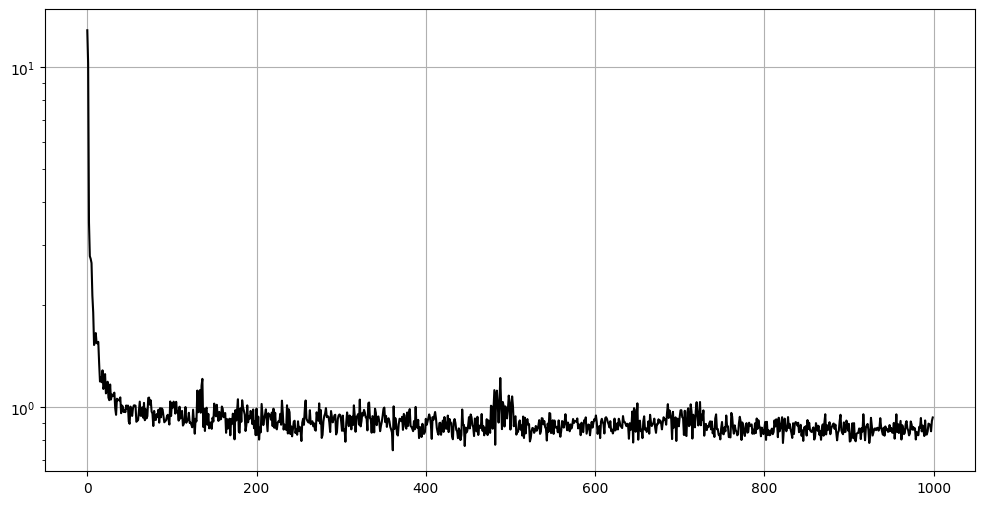

In [388]:
matplotlib.rcParams['figure.figsize'] = [12,6]
fig, ax = plt.subplots()

ax.plot(np.arange(len(losses)), losses, color="black")
ax.set_yscale("log")
ax.grid()

plt.show()


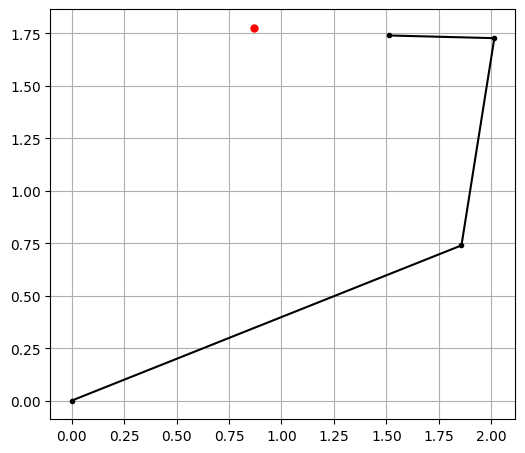

In [393]:
pos_in = torch.tensor([
    np.random.uniform(0.5, 2.5),
    np.random.uniform(0.5, 2.5),
])
angles_out = model(pos_in)

x = [0]
y = [0]

pos_x = angles_out[0].cos() * lengths[0]
pos_y = angles_out[0].sin() * lengths[0]

x.append(pos_x.detach().numpy())
y.append(pos_y.detach().numpy())

pos_x = pos_x + (angles_out[0] + angles_out[1]).cos() * lengths[1]
pos_y = pos_y + (angles_out[0] + angles_out[1]).sin() * lengths[1]

x.append(pos_x.detach().numpy())
y.append(pos_y.detach().numpy())

pos_x = pos_x + (angles_out[0] + angles_out[1] + angles_out[2]).cos() * lengths[2]
pos_y = pos_y + (angles_out[0] + angles_out[1] + angles_out[2]).sin() * lengths[2]

x.append(pos_x.detach().numpy())
y.append(pos_y.detach().numpy())

matplotlib.rcParams['figure.figsize'] = [6,6]
fig, ax = plt.subplots()

ax.plot(x, y, color="black", ms=3, marker="o")
ax.plot(pos_in[0], pos_in[1], color="red", ms=5, marker="o")
ax.set_aspect("equal")
ax.grid()

plt.show()